## Createion of new root trees
With a new branch containing a vector histogram caracteristics:
* Mean (X and Y), Sigma (X and Y), Kurtosis, Skewness and MaximumBin

In [1]:
import ROOT
import uproot
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from array import array
from matplotlib.colors import LogNorm

Welcome to JupyROOT 6.28/06


In [2]:
name = ["run74_new_v4", "run74"]

#### If you have **already** created the new files you can **skip** the next cells ...

In [3]:
c_func = """
vector<vector<double>> histo_var(unsigned long long evt, vector<vector<short>> raw_q, vector<string> mmChamber, vector<int> mmStrip, vector<int> t_max_q){
    vector<vector<double>> histo_var_temp;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        vector<double> histo_temp = {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0};
        if(mmChamber.at(i) == "Tmm-Lecce2" || mmChamber.at(i) == "Tmm-Lecce1"){
            TString st=Form("event_%llu_strip_%d_onChamber_",evt, mmStrip.at(i));
            TH1F *q_per_strip = new TH1F(st+(TString)mmChamber.at(i), st+(TString)mmChamber.at(i), 15, 0, 15);
            double meanY=0.0;
            int count=0;
            for(Int_t j=0; j<raw_q.at(i).size() ; j++){
                double charge= (raw_q.at(i)).at(j);
                meanY = meanY+charge;
                count++;
                if (charge<=0){ charge = 0.001; }
                q_per_strip->SetBinContent(j+1, charge);
            }
            meanY=meanY/count;
            double SquaredDevY = 0.0;
            for(Int_t j=0; j<raw_q.at(i).size() ; j++){
                double charge= (raw_q.at(i)).at(j);
                double deviation = charge - meanY;
                SquaredDevY += deviation * deviation;
            }
            SquaredDevY=TMath::Sqrt(SquaredDevY / count);
            histo_temp[0]=q_per_strip->GetMean();
            histo_temp[1]=meanY;
            histo_temp[2]=TMath::Sqrt(q_per_strip->GetRMS());
            histo_temp[3]=SquaredDevY;
            histo_temp[4]=q_per_strip->GetKurtosis();
            histo_temp[5]=q_per_strip->GetSkewness();
            histo_temp[6]=q_per_strip->GetMaximumBin();
            delete q_per_strip;
        }
        histo_var_temp.push_back(histo_temp);
            
    }//End mmStrip.size() loop
    return histo_var_temp;
}
vector<short> new_max_q(vector<short> max_q, vector<vector<short>> raw_q, vector<string> mmChamber, vector<int> mmStrip, vector<int> t_max_q){
    vector<short> max_q_temp = max_q;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        if(mmChamber.at(i) == "Tmm-Lecce2" || mmChamber.at(i) == "Tmm-Lecce1"){
            Int_t j=0;
            short max_charge = 0.0;
            for(j=0; j<raw_q.at(i).size() ; j++){
                short charge= (raw_q.at(i)).at(j);
                if(charge > max_charge){
                    max_charge = charge;
                }
            }
            max_q_temp.at(i) = max_charge;
        }
    }//End mmStrip.size() loop
    return max_q_temp;
}

vector<int> new_t_max_q(vector<short> max_q, vector<vector<short>> raw_q, vector<string> mmChamber, vector<int> mmStrip, vector<int> t_max_q){
    vector<int> t_max_q_temp = t_max_q;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        if(mmChamber.at(i) == "Tmm-Lecce2" || mmChamber.at(i) == "Tmm-Lecce1"){
            Int_t j=0;
            short max_charge = 0.0;
            int temp_max = 0.0;
            for(j=0; j<raw_q.at(i).size() ; j++){
                short charge= (raw_q.at(i)).at(j);
                if(charge > max_charge){
                    max_charge = charge;
                    temp_max = j+1;
                }
            }
            t_max_q_temp.at(i) = temp_max;
        }
    }//End mmStrip.size() loop
    return t_max_q_temp;
}

vector<vector<short>> conv_raw_q(ROOT::VecOps::RVec<vector<short>> raw_q, ROOT::VecOps::RVec<int> mmStrip){
    vector<vector<short>> temp;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        vector<short> pippo;
        for(Int_t j=0; j<raw_q.at(i).size() ; j++){
            pippo.push_back((short)(raw_q.at(i).at(j)));
        }
        temp.push_back(pippo);
    }
    return temp;
}

vector<string> conv_mmChamber(ROOT::VecOps::RVec<string> mmChamber, ROOT::VecOps::RVec<int> mmStrip){
    vector<string> temp;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        temp.push_back(mmChamber.at(i));
    }
    return temp;
}

vector<unsigned int> conv_uint(ROOT::VecOps::RVec<unsigned int> x_var, ROOT::VecOps::RVec<int> mmStrip){
    vector<unsigned int> temp;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        temp.push_back(x_var.at(i));
    }
    return temp;
}

vector<int> conv_int(ROOT::VecOps::RVec<int> x_var, ROOT::VecOps::RVec<int> mmStrip){
    vector<int> temp;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        temp.push_back(x_var.at(i));
    }
    return temp;
}

vector<char> conv_char(ROOT::VecOps::RVec<char> x_var, ROOT::VecOps::RVec<int> mmStrip){
    vector<char> temp;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        temp.push_back(x_var.at(i));
    }
    return temp;
}

vector<short> conv_short(ROOT::VecOps::RVec<short> x_var, ROOT::VecOps::RVec<int> mmStrip){
    vector<short> temp;
    for(Int_t i = 0; i<mmStrip.size() ; i++){
        temp.push_back(x_var.at(i));
    }
    return temp;
}

"""

In [4]:
ROOT.gInterpreter.Declare(c_func) # Dichiarare la funzione all'interprete ROOT

ROOT.gInterpreter.GenerateDictionary("vector<vector<short> >","vector")
ROOT.gInterpreter.GenerateDictionary("vector<string>","vector")

ROOT.EnableImplicitMT() #Per eseguire in parallelo

In [5]:
for i in range(2):
    start_time = time.time() 
    df = ROOT.RDataFrame("apv_raw", "../../Aug_TestBean_File_IN/"+name[i]+".root")

    df = df.Redefine("raw_q","conv_raw_q(raw_q,mmStrip)")
    df = df.Redefine("mmChamber","conv_mmChamber(mmChamber,mmStrip)")
    df = df.Redefine("srsFec","conv_uint(srsFec,mmStrip)")
    df = df.Redefine("srsFec","conv_uint(srsFec,mmStrip)")
    df = df.Redefine("srsChip","conv_uint(srsChip,mmStrip)")
    df = df.Redefine("srsChan","conv_uint(srsChan,mmStrip)")
    df = df.Redefine("mmLayer","conv_int(mmLayer,mmStrip)")
    df = df.Redefine("t_max_q","conv_int(t_max_q,mmStrip)")
    df = df.Redefine("mmReadout","conv_char(mmReadout,mmStrip)")
    df = df.Redefine("max_q","conv_short(max_q,mmStrip)")
    df = df.Redefine("mmStrip","conv_int(mmStrip,mmStrip)")

    df = df.Define("histo_v", "histo_var(evt, raw_q, mmChamber, mmStrip, t_max_q)");
    new_tree = df.Snapshot("apv_raw", "../../Aug_TestBean_File_OUT/"+name[i]+"_plot.root") 

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Tempo trascorso: {elapsed_time} secondi")


Tempo trascorso: 12.466128826141357 secondi
Tempo trascorso: 10.58039665222168 secondi


## Plottiong of histograms:
Comparison of:
* Mean (X and Y), Sigma (X and Y), Kurtosis, Skewness and MaximumBin

Before and after the selection applied with the fit.

In [6]:
histoNames = [
    "MeanT",
    "MeanQ",
    "sigmaT",
    "sigmaQ",
    "Kurtosis",
    "Skewness",
    "MaximumBin",
]
histoM = [
    "N_StripL1",
    "N_StripL2"
]

In [7]:
file_name="hitso_out.root"
f = ROOT.TFile(file_name, "RECREATE")
f.Close()

In [8]:
def get_histo_from_root(rootFileName, pre_post):
    file = ROOT.TFile(rootFileName, "READ")
    tree = file.Get("apv_raw")

    histo_v = ROOT.std.vector(ROOT.std.vector(ROOT.Double_t()))()
    mmChamber = ROOT.std.vector(str)()
    raw_q = ROOT.std.vector(ROOT.std.vector(ROOT.Short_t()))()

    tree.SetBranchAddress("histo_v", ROOT.AddressOf(histo_v))
    tree.SetBranchAddress("mmChamber", ROOT.AddressOf(mmChamber))
    tree.SetBranchAddress("raw_q", ROOT.AddressOf(raw_q))

    numEntries = tree.GetEntries()

    numBins = 100
    histoRanges = [
        [0, 13],    # MeanT
        [0, 2000],  # MeanQ
        [0, 2.5],   # sigmaT 
        [0, 500],    # sigmaQ
        [-3, 2],     # Kurtosis
        [-1, 1.5],   # Skewness 
        [0, 15],     # MaximumBin 
    ]        
    histograms = []
    for i in range(len(histoNames)):
        histograms.append(ROOT.TH1D(f"histo_{histoNames[i]}", f"Histogram {histoNames[i]}", numBins, histoRanges[i][0], histoRanges[i][1]))
        histograms[i].SetName(f"{histoNames[i]}_{pre_post}")

    file2 = ROOT.TFile("hitso_out.root", "UPDATE")
    new_tree = ROOT.TTree(f"histotree_{pre_post}", "New Tree")
    branch_data = [array('d', [0.0]) for _ in range(len(histoNames))]

    for i, n in enumerate(histoNames):
        new_tree.Branch(n, branch_data[i], f"{n}/D")

    N_StripL1=[]
    N_StripL2=[]
    for entry in range(numEntries):
        tree.GetEntry(entry)
        cont1=0
        cont2=0
        for j in range(len(histo_v)):
            max_q = 0
            for k in range(len(raw_q[j])):
                if raw_q[j][k]>max_q: 
                    max_q = raw_q[j][k]
            if len(histo_v[j]) > i and (mmChamber[j] == "Tmm-Lecce2" or mmChamber[j] == "Tmm-Lecce1") and max_q > 10:
                for i in range(len(histoNames)):
                    histograms[i].Fill(histo_v[j][i])
                    branch_data[i][0] = histo_v[j][i]
                new_tree.Fill()
            if (mmChamber[j] == "Tmm-Lecce1") and max_q > 0:
                cont1=cont1+1
            if (mmChamber[j] == "Tmm-Lecce2") and max_q > 0:
                cont2=cont2+1
        N_StripL1.append(cont1)
        N_StripL2.append(cont2)
    new_tree.Write()
    for i in range(len(histoNames)):
        histograms[i].Write()
    file2.Close()
    file.Close()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.hist(N_StripL1, bins=numBins, edgecolor='black', histtype='barstacked', color='blue', alpha=0.7)
    ax1.set_xlabel(histoM[0])
    ax1.set_ylabel('# strip')  # Aggiungi etichetta dell'asse y se necessario
    ax1.set_title('TMML1')  # Aggiungi un titolo

    ax2.hist(N_StripL2, bins=numBins, edgecolor='black', histtype='barstacked', color='green', alpha=0.7)
    ax2.set_xlabel(histoM[1])
    ax2.set_ylabel('# strip')  # Aggiungi etichetta dell'asse y se necessario
    ax2.set_title('TMML2')  # Aggiungi un titolo

    plt.show()


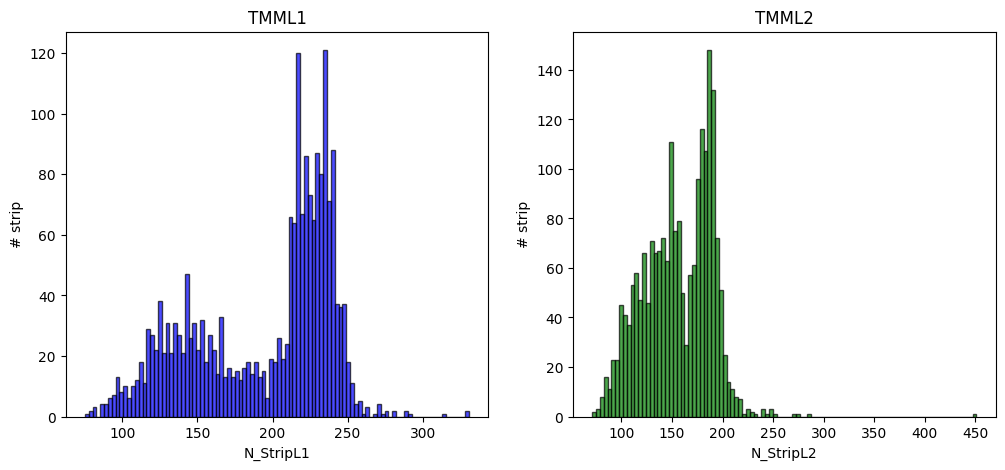

Tempo trascorso: 42.07884907722473 secondi


In [9]:
start_time = time.time() 
get_histo_from_root("/Users/marcobuonsante/Downloads/HCAL/Aug_TestBean_File_OUT/"+name[1]+"_plot.root", "pre")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tempo trascorso: {elapsed_time} secondi")

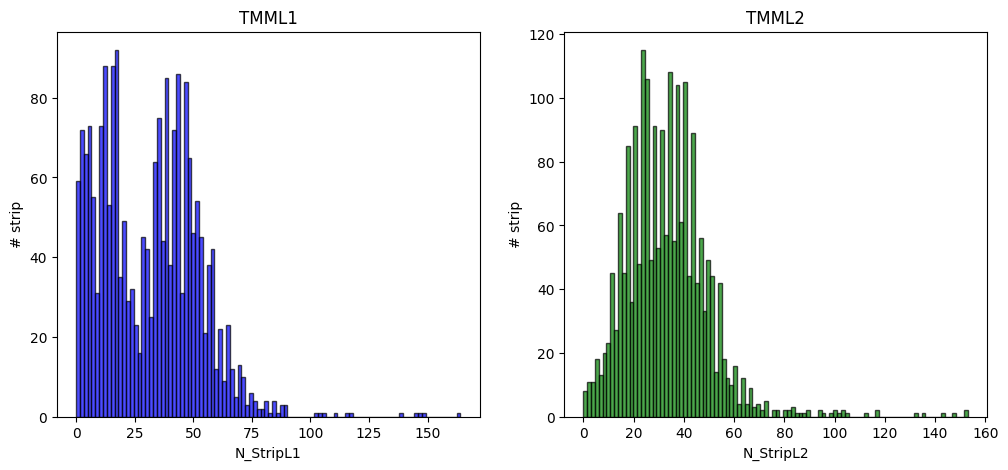

Tempo trascorso: 26.24201011657715 secondi


In [10]:
start_time = time.time() 
get_histo_from_root("/Users/marcobuonsante/Downloads/HCAL/Aug_TestBean_File_OUT/"+name[0]+"_plot.root", "post")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tempo trascorso: {elapsed_time} secondi")

In [11]:
def plot_histograms_from_file(file_name, histo_name, scale, ax=None):
    root_file = ROOT.TFile(file_name, "READ")

    histo1 = root_file.Get(f"{histo_name}_post")
    histo2 = root_file.Get(f"{histo_name}_pre")

    if not histo1 or not histo2:
        print(f"Istogrammi non trovati nel file per il nome {histo_name}")
        return

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
        
    entries1 = histo1.GetEntries()
    entries2 = histo2.GetEntries()

    integral1 = histo1.Integral()
    integral2 = histo2.Integral()
    if integral1 > 0:
        histo1.Scale(1.0 / integral1)
    if integral2 > 0:
        histo2.Scale(1.0 / integral2)
    
    bin_centers = [histo1.GetBinCenter(bin) for bin in range(1, histo1.GetNbinsX() + 1)]
    bin_contents1 = [histo1.GetBinContent(bin) for bin in range(1, histo1.GetNbinsX() + 1)]
    bin_contents2 = [histo2.GetBinContent(bin) for bin in range(1, histo2.GetNbinsX() + 1)]
    
    ax.bar(bin_centers, bin_contents1, width=histo1.GetBinWidth(1), label=f"Post Sel. - {histo_name}", color='blue', alpha=0.7)
    ax.bar(bin_centers, bin_contents2, width=histo2.GetBinWidth(1), label=f"Pre Sel. - {histo_name}", color='red', alpha=0.7)
    
    ax.set_yscale(scale)
    ax.set_xlabel(histo_name)
    ax.set_ylabel("Counts (" + scale + " scale)")
    ax.legend()
    ax.grid(True)
    ax.set_title(f"Histogram Comparison - {histo_name}")

    ax.text(0.05, 0.9, f"Entries (Post Sel.): {entries1:.2f}", transform=ax.transAxes, fontsize=10, color='black')
    ax.text(0.05, 0.82, f"Entries (Pre Sel.): {entries2:.2f}", transform=ax.transAxes, fontsize=10, color='black')

    root_file.Close()


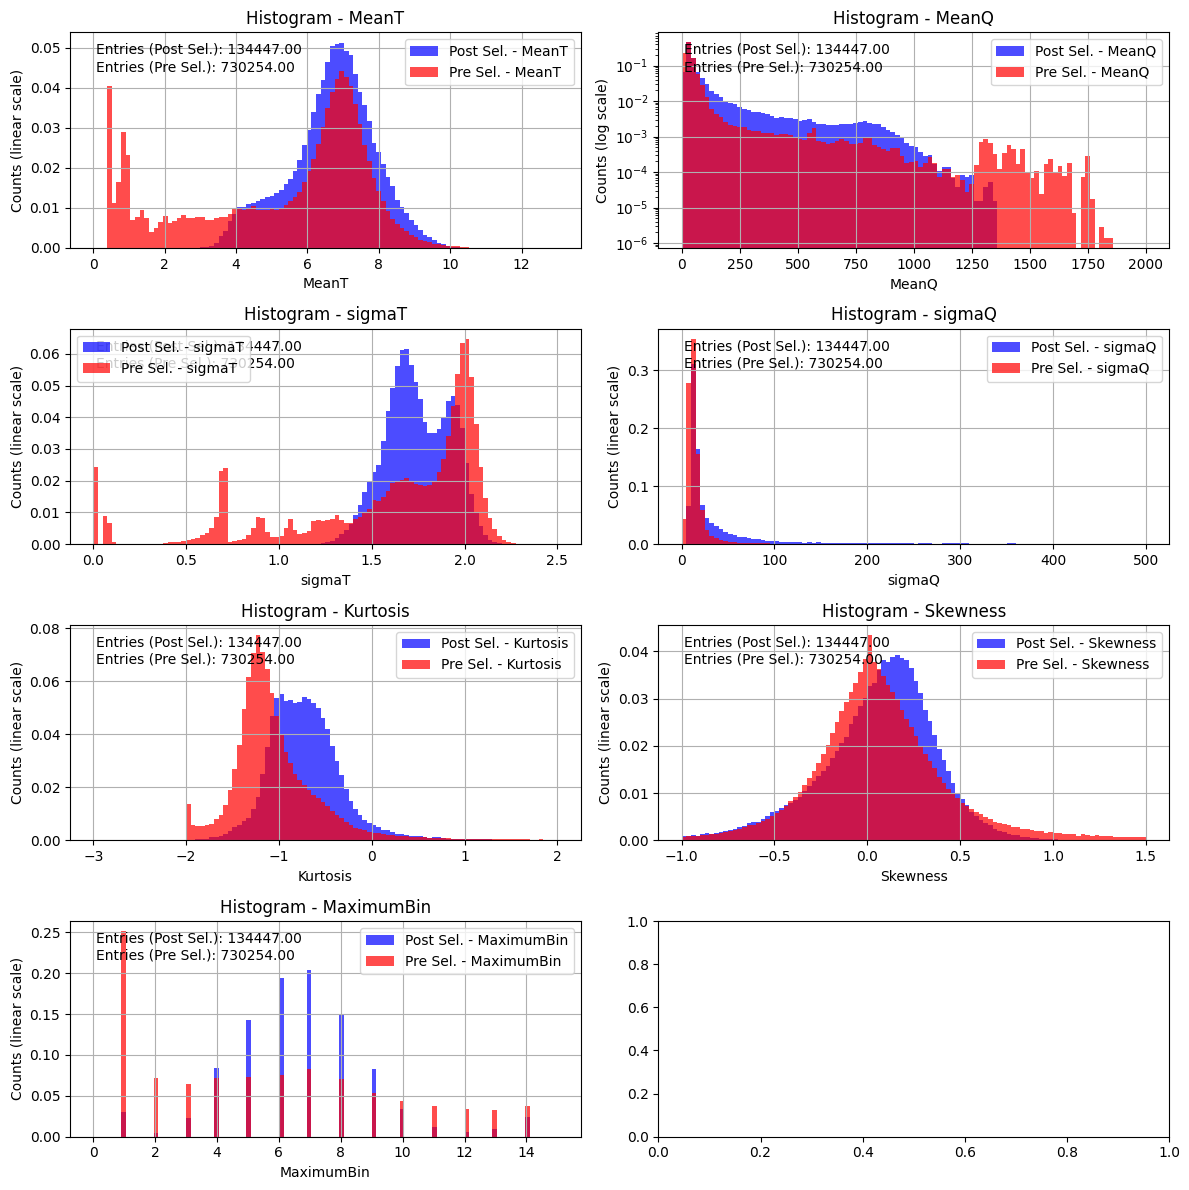

In [12]:
num_rows = 4  # Numero di righe
num_cols = 2  # Numero di colonne

# Crea una figura con una griglia di plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))  # Imposta le dimensioni della figura

for i, ax in enumerate(axes.flat):
    scale = "linear"
    if i == 1:
        scale = "log"
    if (i != 7) :
        plot_histograms_from_file(file_name, histoNames[i], scale, ax)
        ax.set_title(f"Histogram - {histoNames[i]}")
        ax.grid(True)

# Imposta uno spazio tra i plot
plt.tight_layout()

# Mostra i plot affiancati
plt.show()

## Correlation matrices
* Between histograms variables pre and post selections

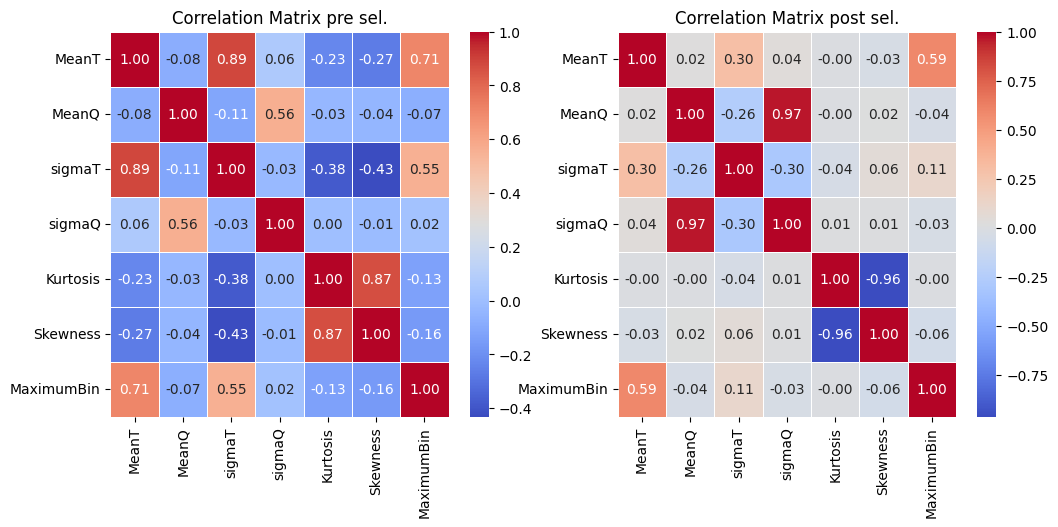

In [13]:
file = uproot.open("hitso_out.root")  

tree_pre = file["histotree_pre"]
tree_post = file["histotree_post"]

data_pre = tree_pre.arrays(library="pd")
data_post = tree_post.arrays(library="pd")

correlation_matrix_pre = data_pre.corr()
correlation_matrix_post = data_post.corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(correlation_matrix_pre, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10}, ax=ax1)
ax1.set_title('Correlation Matrix pre sel.')

sns.heatmap(correlation_matrix_post, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10}, ax=ax2)
ax2.set_title('Correlation Matrix post sel.')

plt.show()

## 2D plot between hitso variables
### Mean vs Sigma Pre Selections

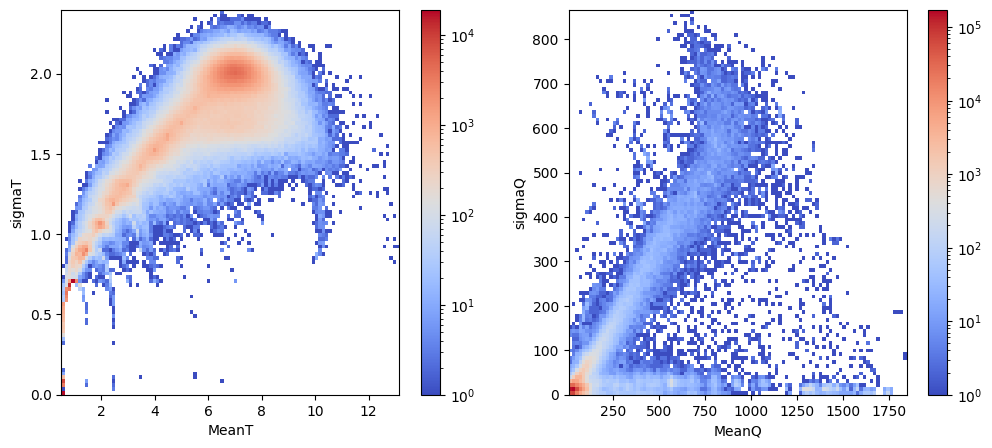

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hist1 = ax1.hist2d(data_pre['MeanT'], data_pre['sigmaT'], bins=100, cmap='coolwarm', norm=LogNorm())
ax1.set_xlabel('MeanT')
ax1.set_ylabel('sigmaT')
plt.colorbar(hist1[3], ax=ax1)

hist2 = ax2.hist2d(data_pre['MeanQ'], data_pre['sigmaQ'], bins=100, cmap='coolwarm', norm=LogNorm())
ax2.set_xlabel('MeanQ')
ax2.set_ylabel('sigmaQ')
plt.colorbar(hist2[3], ax=ax2)

plt.show()

### Mean vs Sigma Post Selections

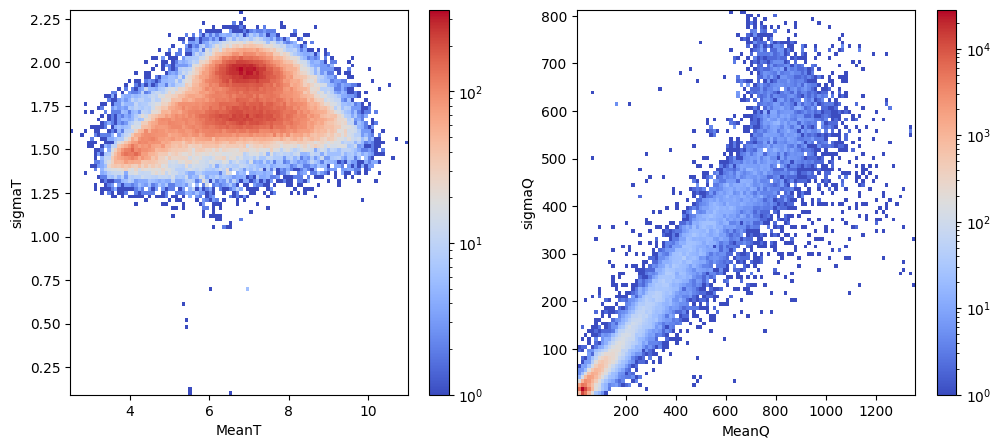

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hist1 = ax1.hist2d(data_post['MeanT'], data_post['sigmaT'], bins=100, cmap='coolwarm', norm=LogNorm())
ax1.set_xlabel('MeanT')
ax1.set_ylabel('sigmaT')
plt.colorbar(hist1[3], ax=ax1)

hist2 = ax2.hist2d(data_post['MeanQ'], data_post['sigmaQ'], bins=100, cmap='coolwarm', norm=LogNorm())
ax2.set_xlabel('MeanQ')
ax2.set_ylabel('sigmaQ')
plt.colorbar(hist2[3], ax=ax2)
plt.show()

### SigmaX vs SigmaY

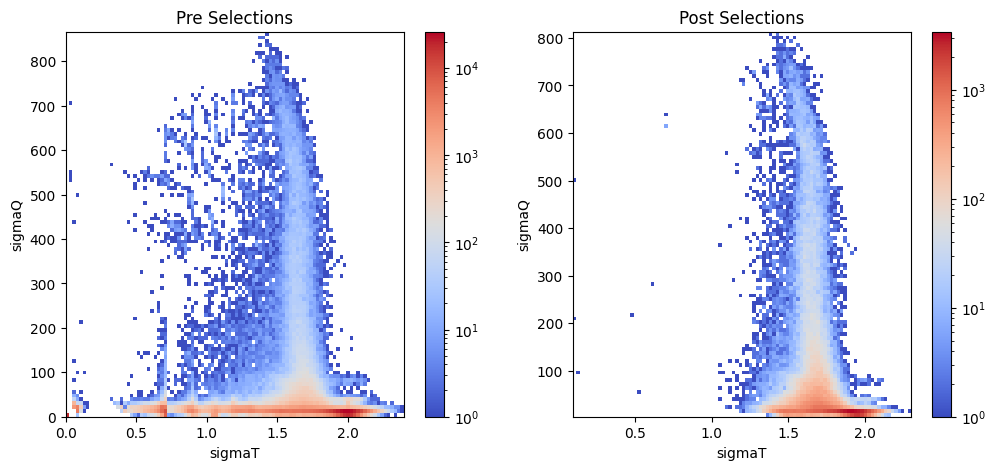

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hist1 = ax1.hist2d(data_pre['sigmaT'], data_pre['sigmaQ'], bins=100, cmap='coolwarm', norm=LogNorm())
ax1.set_xlabel('sigmaT')
ax1.set_ylabel('sigmaQ')
ax1.set_title('Pre Selections')
plt.colorbar(hist1[3], ax=ax1)

hist2 = ax2.hist2d(data_post['sigmaT'], data_post['sigmaQ'], bins=100, cmap='coolwarm', norm=LogNorm())
ax2.set_xlabel('sigmaT')
ax2.set_ylabel('sigmaQ')
ax2.set_title('Post Selections')
plt.colorbar(hist2[3], ax=ax2)
plt.show()

### Skewness vs Kurtosis

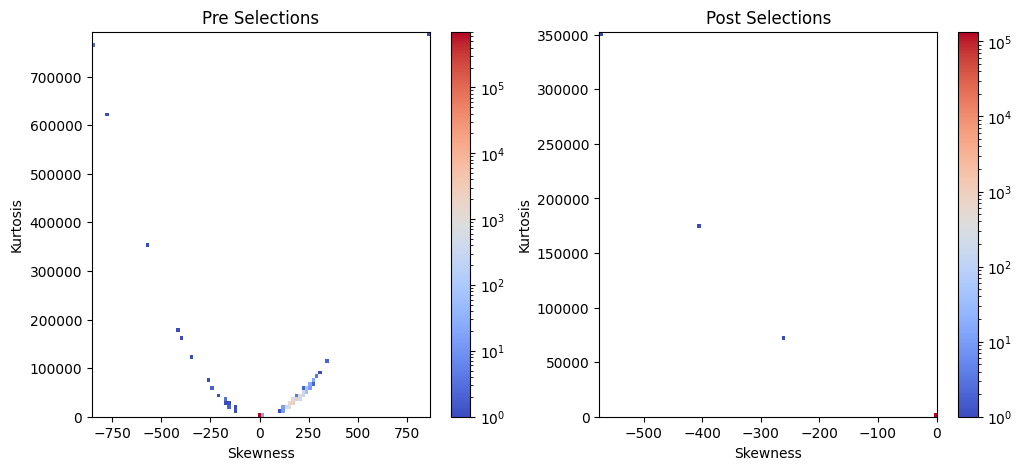

In [18]:
data_pre.dropna(subset=['Kurtosis', 'Skewness'], inplace=True)
data_post.dropna(subset=['Kurtosis', 'Skewness'], inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hist1 = ax1.hist2d(data_pre['Skewness'], data_pre['Kurtosis'], bins=100, cmap='coolwarm', norm=LogNorm())
ax1.set_xlabel('Skewness')
ax1.set_ylabel('Kurtosis')
ax1.set_title('Pre Selections')
plt.colorbar(hist1[3], ax=ax1)

hist2 = ax2.hist2d(data_post['Skewness'], data_post['Kurtosis'], bins=100, cmap='coolwarm', norm=LogNorm())
ax2.set_xlabel('Skewness')
ax2.set_ylabel('Kurtosis')
ax2.set_title('Post Selections')
plt.colorbar(hist2[3], ax=ax2)
plt.show()

### Observation:
Mainly events with low Skewness and Kurtosis in absolute value are selected. The few who despite everything pass the selection are clearly not correct signals:

In [21]:
condizione = ((data_post['Skewness'] < -3) | (data_post['Kurtosis'] > 3 )) & (data_post['MeanQ'] > 50 )
print(data_post[condizione][['MeanT', 'MeanQ', 'sigmaT', 'sigmaQ']])

           MeanT       MeanQ    sigmaT      sigmaQ
3507    6.078935  528.125000  1.243065  573.876389
5706    6.549049   71.750000  1.075123   94.941758
5707    6.482991  298.875000  1.044744  359.953274
5710    6.216144   62.375000  1.120357   76.694096
11053   6.149111   61.000000  1.347004   76.052613
14764   6.120984   70.250000  1.235686   80.333290
30499   6.767649   97.444444  1.279355   93.378693
32361   6.328111   71.125000  1.057744   98.010762
32362   5.966891   58.625000  1.259154   79.446425
39257   6.697804  738.666667  1.269972  728.465816
48262   6.499984   68.714286  0.091753  499.134884
52608   6.065379  537.250000  1.228766  566.955851
53054   8.844214   56.250000  1.445870   93.064606
62271   5.499972   72.500000  0.100367  210.393877
62272   5.441913   92.333333  0.483782  220.898670
73565   6.171665  633.500000  1.192643  713.169861
74065   6.720579  736.444444  1.256817  731.735549
76386   6.168902  633.875000  1.198109  713.441385
79138   6.136523  641.375000  1

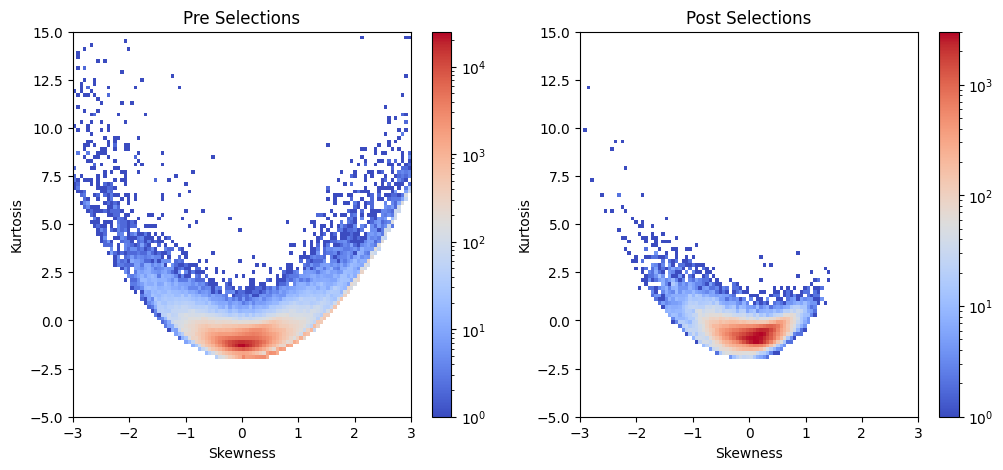

In [22]:
data_pre.dropna(subset=['Kurtosis', 'Skewness'], inplace=True)
data_post.dropna(subset=['Kurtosis', 'Skewness'], inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hist1 = ax1.hist2d(data_pre['Skewness'], data_pre['Kurtosis'], bins=100, cmap='coolwarm', norm=LogNorm(),range=[[-3, 3], [-5, 15]])
ax1.set_xlabel('Skewness')
ax1.set_ylabel('Kurtosis')
ax1.set_title('Pre Selections')
plt.colorbar(hist1[3], ax=ax1)

hist2 = ax2.hist2d(data_post['Skewness'], data_post['Kurtosis'], bins=100, cmap='coolwarm', norm=LogNorm(),range=[[-3, 3], [-5, 15]])
ax2.set_xlabel('Skewness')
ax2.set_ylabel('Kurtosis')
ax2.set_title('Post Selections')
plt.colorbar(hist2[3], ax=ax2)
plt.show()

### MeanY/sigmaY

Text(0.5, 1.0, 'Post Selections')

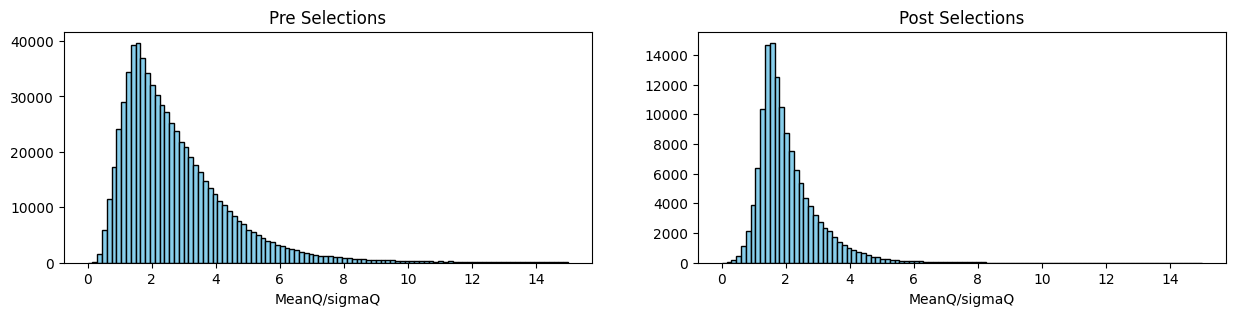

In [23]:
data_pre['rapporto'] = data_pre['MeanQ'] / data_pre['sigmaQ']
data_pre['rapporto'] = data_pre['rapporto'].replace([np.inf, -np.inf], 999)
data_post['rapporto'] = data_post['MeanQ'] / data_post['sigmaQ']
data_post['rapporto'] = data_post['rapporto'].replace([np.inf, -np.inf], 999)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
hist1 = ax1.hist(data_pre['rapporto'], bins=100, color='skyblue', edgecolor='black',range=(0, 15))
ax1.set_xlabel('MeanQ/sigmaQ')
ax1.set_title('Pre Selections')

hist2 = ax2.hist(data_post['rapporto'], bins=100, color='skyblue', edgecolor='black',range=(0, 15))
ax2.set_xlabel('MeanQ/sigmaQ')
ax2.set_title('Post Selections')
